In [1]:
import source.preprocess as prep
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt

In [2]:
from source.model import *

In [3]:
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')

if torch.cuda.is_available():
    print("=> Using GPU")
    print("CUDA device count =")
    print (torch.cuda.device_count())
    print("Selecting decvice = cuda:0")
    device = torch.device("cuda:0")
    print("Device name = ")
    print (torch.cuda.get_device_name(0))
else:
    print("=> Using CPU")
    device = torch.device("cpu")

=> Using GPU
CUDA device count =
2
Selecting decvice = cuda:0
Device name = 
NVIDIA GeForce RTX 2080


In [4]:
randstate = 0
np.random.seed(randstate)
torch.manual_seed(randstate)
if device == torch.device("cuda:0"):
    randstate = 0 # RCC fela #1234
    np.random.seed(randstate)
    torch.manual_seed(randstate)
    torch.cuda.manual_seed_all(randstate)

# Load data (SH3)

In [5]:
# path to collect the sequence data    
main_path = 'training_data'    
SH3_path = main_path + '/sh3_59.fasta'

# read the sequence data
SH3_sequences = prep.get_seq(SH3_path)

# read relative enrichment score
SH3_RE_raw = np.load('training_data/RE.npz')['RE_mapping']

# standardize RE for training
mask = ~np.isnan(SH3_RE_raw)
SH3_RE= (SH3_RE_raw - np.mean(SH3_RE_raw[mask])) / np.std(SH3_RE_raw[mask])

# clean up data
sample, positions = len(SH3_sequences), len(SH3_sequences[0])
SH3_MSA = prep.create_MSA(SH3_sequences, sample, positions)

# pandas dataframe format
SH3_df = pd.DataFrame(SH3_MSA)
SH3_df.columns = ['Sequence']

SH3_onehot_inputs = prep.create_one_hot(SH3_df)

# hyperparameters ...

z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = SH3_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width

## Train and test function

In [6]:
# The training function
def train(model, epoch, batch_per_epoch, v_train, y):
    
    optimizer = optim.Adam(model.parameters(), lr = 2e-5, weight_decay=0)
    
    # batching and training
    ind = np.arange(v_train.shape[0])
    
    y = y.reshape(-1,1)
    
    for i in range(batches_per_epoch):
        data = torch.FloatTensor(v_train[np.random.choice(ind, size=batch_size)]).to(device)
        data_y = torch.FloatTensor(y[np.random.choice(ind, size=batch_size)]).to(device)

        optimizer.zero_grad()
        z, recon_batch, y_pred = model(data)
        loss, _, _, _ = loss_ss(recon_batch, data, z, data_y, y_pred, device)
        loss.backward()
        optimizer.step()
    
    # training loss
    data = torch.FloatTensor(v_train).to(device)
    data_y = torch.FloatTensor(y).to(device)
    
    z, recon_batch, y_pred = model(data)
    train_loss, train_loss_rec, train_loss_mmd, train_losss_pred = \
    loss_ss(recon_batch, data, z, data_y, y_pred, device)
    
    train_loss = train_loss.cpu().detach().numpy() 
    train_loss_rec = train_loss_rec.cpu().detach().numpy() 
    train_loss_mmd = train_loss_mmd.cpu().detach().numpy() 
    train_loss_pred = train_losss_pred.cpu().detach().numpy() 
    
    if (epoch % 2 == 0):
        print('====> Epoch %d done! Train loss = %.2e, Train loss rec = %.2e, Train loss mmd = %.2e, \
Train loss pred = %.2e' \
              % (epoch, train_loss, train_loss_rec, train_loss_mmd, train_loss_pred))
    
    return train_loss, train_loss_rec, train_loss_mmd, train_loss_pred 

def test(model, epoch, v_val, y):
    model.eval()
    
    with torch.no_grad():
        data = torch.FloatTensor(v_val)
        data_y = torch.FloatTensor(y) 
        
        data = data.to(device)
        data_y = data_y.to(device)
        
        z, recon_batch, y_pred = model(data)
        
        test_loss, test_loss_rec, test_loss_mmd, test_loss_pred = \
        loss_ss(recon_batch, data, z, data_y, y_pred, device)
        
        test_loss = test_loss.cpu().detach().numpy() 
        test_loss_rec = test_loss_rec.cpu().detach().numpy() 
        test_loss_pred = test_loss_pred.cpu().detach().numpy() 
        test_loss_mmd = test_loss_mmd.cpu().detach().numpy() 
        
    if (epoch % 2 == 0):
        print('====> Test loss = %.2e, Test loss rec: %.2e, Test loss mmd = %.2e, Test loss pred = %.2e\n' \
              %(test_loss, test_loss_rec, test_loss_mmd, test_loss_pred))
    return test_loss, test_loss_rec, test_loss_mmd, test_loss_pred

## Find best epoch 

In [11]:
batch_size = 64
over_batch = 8
nb_epochs = 30
val_frac = .15

batches_per_epoch = np.int32(over_batch*np.ceil(SH3_onehot_inputs.shape[0]/batch_size))

idx = np.arange(len(SH3_onehot_inputs))

model = SS_MMD(z_dim, seq_len, aa_var, alpha).to(device)
model.train()

v_train, v_val, idx_train, idx_val = \
train_test_split(SH3_onehot_inputs, idx, test_size=val_frac, random_state=randstate)

y_train, y_val, idx_train, idx_val = \
train_test_split(SH3_RE, idx, test_size=val_frac, random_state=randstate)

loss_train = []
loss_test = []

for epoch in range(1, nb_epochs+1):
    tl = train(model, epoch, batches_per_epoch, v_train, y_train)
    ltest = test(model, epoch, v_val, y_val)
    
    loss_train.append(tl)
    loss_test.append(ltest)
    
loss_train = np.array(loss_train)
loss_test = np.array(loss_test)

====> Epoch 2 done! Train loss = 5.96e-01, Train loss rec = 2.96e-02, Train loss mmd = 1.06e-02, Train loss pred = 1.09e+00
====> Test loss = 5.61e-01, Test loss rec: 2.99e-02, Test loss mmd = 1.09e-02, Test loss pred = 1.02e+00

====> Epoch 4 done! Train loss = 5.49e-01, Train loss rec = 2.80e-02, Train loss mmd = 6.96e-03, Train loss pred = 1.02e+00
====> Test loss = 5.46e-01, Test loss rec: 2.83e-02, Test loss mmd = 1.01e-02, Test loss pred = 9.96e-01

====> Epoch 6 done! Train loss = 5.42e-01, Train loss rec = 2.71e-02, Train loss mmd = 4.17e-03, Train loss pred = 1.01e+00
====> Test loss = 5.31e-01, Test loss rec: 2.74e-02, Test loss mmd = 5.15e-03, Test loss pred = 9.87e-01

====> Epoch 8 done! Train loss = 5.46e-01, Train loss rec = 2.58e-02, Train loss mmd = 2.29e-03, Train loss pred = 1.03e+00
====> Test loss = 5.27e-01, Test loss rec: 2.62e-02, Test loss mmd = 3.98e-03, Test loss pred = 9.85e-01

====> Epoch 10 done! Train loss = 5.30e-01, Train loss rec = 2.53e-02, Train los

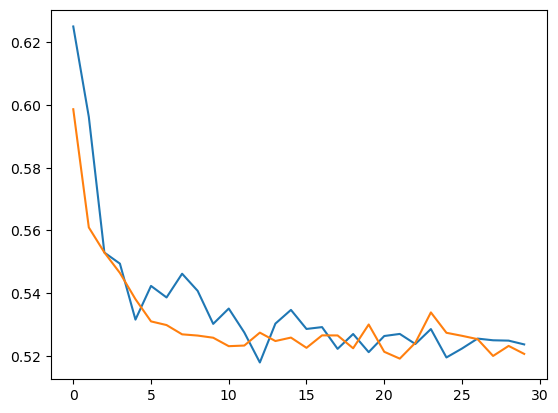

In [12]:
for i in (
loss_train[:,0], 
loss_test[:,0]):
    plt.plot(i)

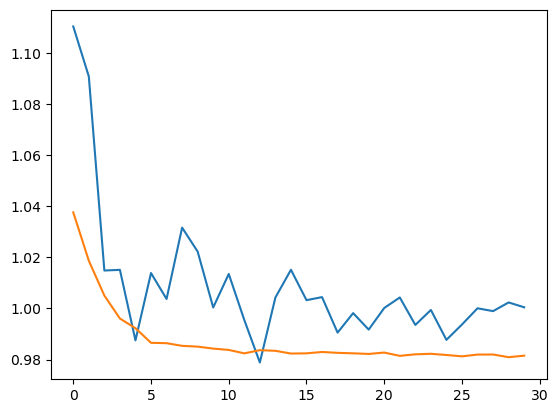

In [15]:
for i in (
loss_train[:,3], 
loss_test[:,3]):
    plt.plot(i)

## Train model on whole dataset

In [16]:
batch_size = 64
over_batch = 8
nb_epochs = 10

batches_per_epoch = np.int32(over_batch*np.ceil(SH3_onehot_inputs.shape[0]/batch_size))

model = SS_MMD(z_dim, seq_len, aa_var, alpha).to(device)
model.train()

loss_train = []
for epoch in range(1, nb_epochs+1):
    tl = train(model, epoch, batches_per_epoch, SH3_onehot_inputs, SH3_RE)
    model.eval()
    loss_train.append(tl)
    
loss_train = np.array(loss_train)

====> Epoch 2 done! Train loss = 5.40e-01, Train loss rec = 2.85e-02, Train loss mmd = 4.40e-03, Train loss pred = 1.01e+00
====> Epoch 4 done! Train loss = 5.47e-01, Train loss rec = 2.68e-02, Train loss mmd = 3.54e-03, Train loss pred = 1.03e+00
====> Epoch 6 done! Train loss = 5.32e-01, Train loss rec = 2.59e-02, Train loss mmd = 1.09e-03, Train loss pred = 1.01e+00
====> Epoch 8 done! Train loss = 5.21e-01, Train loss rec = 2.49e-02, Train loss mmd = 1.14e-03, Train loss pred = 9.87e-01
====> Epoch 10 done! Train loss = 5.22e-01, Train loss rec = 2.45e-02, Train loss mmd = 9.75e-04, Train loss pred = 9.91e-01


In [17]:
model = model.cpu()
torch.cuda.empty_cache() 

In [18]:
save_path = "output/VAE_SH3_semi.pyt"
torch.save(model.state_dict(), save_path)

In [19]:
# one hot encoded for the natural df with annotated phylogeny

v_all = torch.FloatTensor(SH3_onehot_inputs)
nat_z = model.encoder(v_all).detach().numpy() 

# sort the vector based on descending order
re_sort_idx = np.argsort(SH3_RE_raw, axis = None)

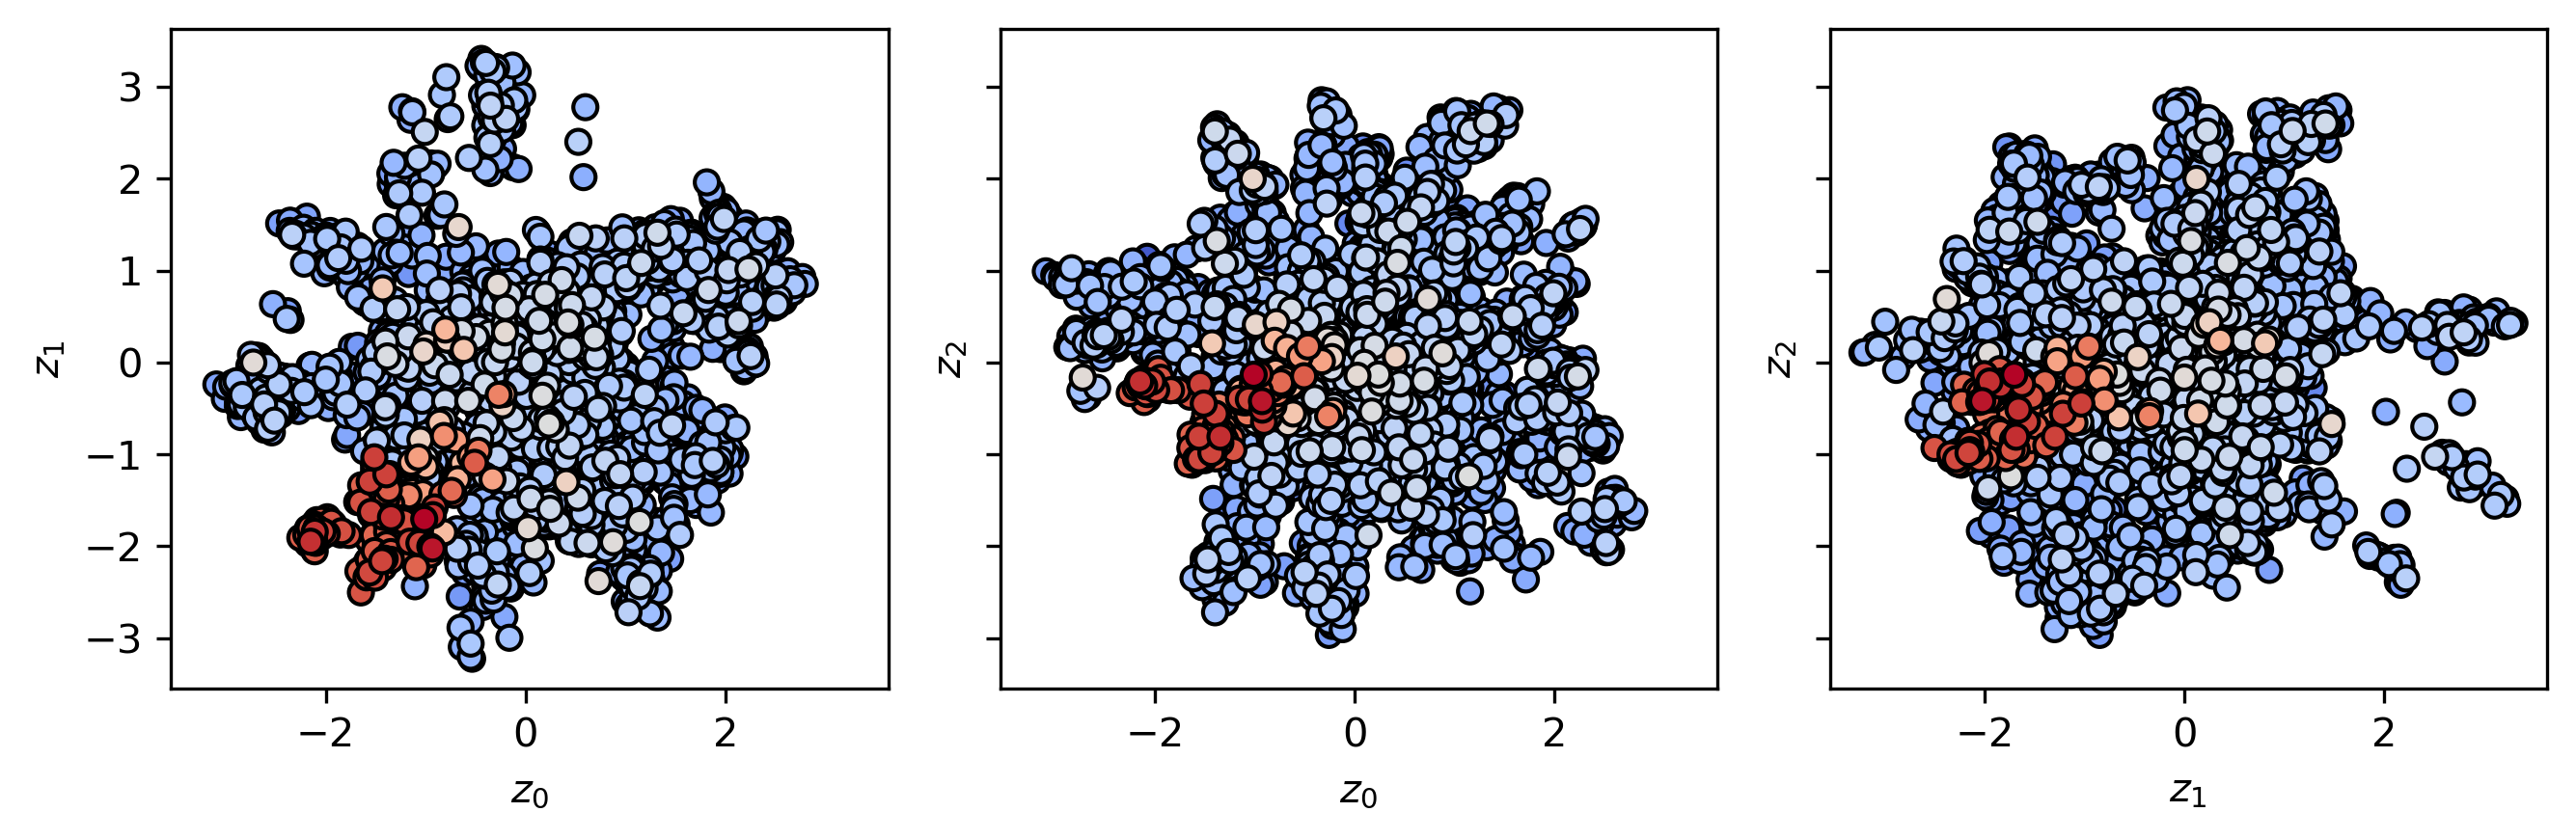

In [20]:
fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )

plot1 = axes[0].scatter(
    nat_z[re_sort_idx,0],
    nat_z[re_sort_idx,1],
    c = SH3_RE_raw[re_sort_idx],
    cmap = 'coolwarm', 
    edgecolor = 'k'
)
plot2 = axes[1].scatter(
    nat_z[re_sort_idx,0],
    nat_z[re_sort_idx,2],
    c = SH3_RE_raw[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)
plot3 = axes[2].scatter(
    nat_z[re_sort_idx,1],
    nat_z[re_sort_idx,2],
    c = SH3_RE_raw[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()